In [10]:
# 모델 Resnet 50 적용

# 이제 모델과 데이터가 준비되었으니, 데이터에 매개변수를 최적화하여 모델을 학습하고, 검증하고, 테스트할 차례입니다.
# 모델을 학습하는 과정은 반복적인 과정을 거칩니다; 각 반복 단계에서 모델은 출력을 추측하고, 추측과 정답 사이의 오류(손실(loss))를 계산하고,
# (이전 장에서 본 것처럼) 매개변수에 대한 오류의 도함수(derivative)를 수집한 뒤,
# 경사하강법을 사용하여 이 파라미터들을 최적화(optimize)합니다.

import torch
from torch import nn


import torch.nn.functional as F
import torch.optim as optim
import os
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

In [11]:
#stride = 건너뛰는 간격. 즉, 여기선 데이터를 얼마나 건너뛰며 볼 것임을 설정. ex : 1= 1픽셀당 하나씩 본다. 2= 2픽셀당 하나씩 본다. (출력 이미지 1/4로 줄어듬.) 3= 3픽셀당 하나씩. (출력 이미지 1/9로 축소)
#kernel = 특징 추출해낼 커널 (필터). 논문에선 7*7사이즈.

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        # 만약 출력 이미지가 입력보다 축소 됐을 시, shortcut 덧셈도 축소된 이미지에 맞춰 행렬 크기를 조정해야 하므로, 그 코드임 아래는
        if stride !=1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [12]:
#resnet 18 ,resnet 50 정의

class Resnet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super(Resnet, self).__init__()
        self.in_planes=64

        self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,64, num_block[0], stride=1)
        self.layer2 = self._make_layer(block,128, num_block[1], stride=2)
        self.layer3 = self._make_layer(block,256, num_block[2], stride=2)
        self.layer4 = self._make_layer(block,512, num_block[3], stride=2)
        self.linear = nn.Linear(512,num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4x4x512
        x = F.avg_pool2d(x,4) #1x1x512
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def Resnet18():
    return Resnet(BasicBlock,[2,2,2,2])

def Resnet50():
    return Resnet(BasicBlock, [3, 4, 6, 3])

In [13]:
# CIFAR-10 데이터 준비

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle =False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
pip install utils

In [15]:
# # Image-Net 데이터 다운로드 및 준비
# import utils

# from google.colab import drive
# drive.mount('/content/drive')
# checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
# if not os.path.exists(checkpoints):
#     os.makedirs(checkpoints)

# import os
# import shutil
# if not os.path.exists('imagenet64'):
#   if not os.path.exists(checkpoints + 'imagenet64.tar'):
#     print("Downloading archive...")
#     os.chdir(checkpoints)
#     !wget https://pjreddie.com/media/files/imagenet64.tar
#     os.chdir('/content/')
#   print("Copying to local runtime...")
#   shutil.copy(checkpoints + 'imagenet64.tar', './imagenet64.tar')
#   print("Uncompressing...")
#   !tar -xf imagenet64.tar
# print("Data ready!")

In [16]:
# #imagenet dataset 준비
# def get_imagenet64_data():
#   # Data augmentation transformations. Not for Testing!
#   normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225])

#   transform_imagenet_train = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),

#     transforms.ToTensor(),
#     normalize,
#   ])

#   transform_imagenet_test = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     normalize,
#   ])

#   trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_imagenet_train)
#   trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4)

#   testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_imagenet_test)
#   testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

#   return {'train': trainloader, 'test': testloader}

# data = get_imagenet64_data()

In [17]:
def cutmix(image1, image2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)  # CutMix 비율을 랜덤하게 생성
    print(image1.size())
    bbx1, bby1, bbx2, bby2 = rand_bbox_fortest(image1.size(), lam)  # 자를 영역 좌표 계산

    # 두 이미지를 CutMix하여 세 번째 이미지 생성
    new_image = image1.clone()
    new_image[:, bby1:bby2, bbx1:bbx2] = image2[:, bby1:bby2, bbx1:bbx2]

    return new_image

In [18]:
def rand_bbox_fortest(size, lam):
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

<ipython-input-18-a1b0128650f3>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-18-a1b0128650f3>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

torch.Size([3, 32, 32])
torch.Size([8, 3, 32, 32])


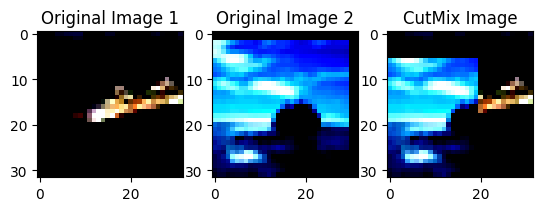

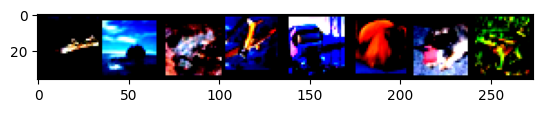

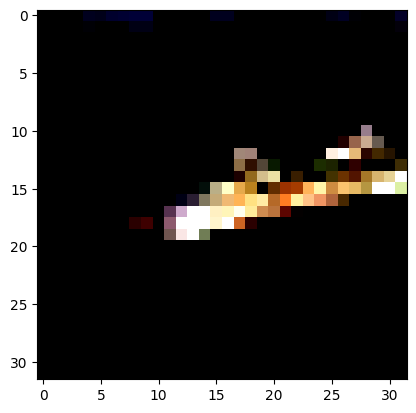

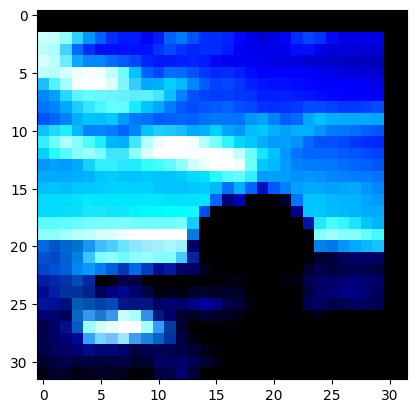

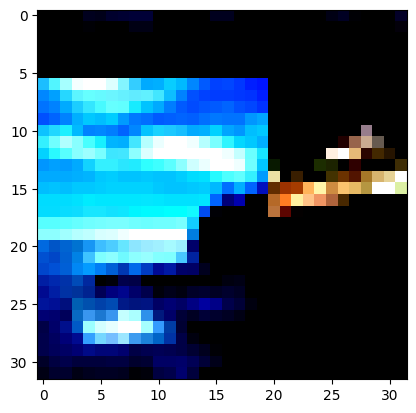

Labels:tensor(8) tensor(8) tensor(6) tensor(0) tensor(9) tensor(5) tensor(5) tensor(6)
torch.Size([8, 3, 32, 32])
torch.Size([8, 3072])


In [19]:
#시험 출력
import numpy as np

dataiter = iter(train_dataloader)
images, labels = dataiter.__next__()
images = images[:8]
cutmix_image=cutmix(images[0],images[1])
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images

plt.subplot(1, 3, 1)
plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.title('Original Image 1')
plt.subplot(1, 3, 2)
plt.imshow(np.transpose(images[1], (1, 2, 0)))
plt.title('Original Image 2')
plt.subplot(1, 3, 3)
plt.imshow(np.transpose(cutmix_image, (1, 2, 0)))
plt.title('CutMix Image')
plt.show()

imshow(torchvision.utils.make_grid(images))
imshow(images[0])
imshow(images[1])
imshow(cutmix_image)
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

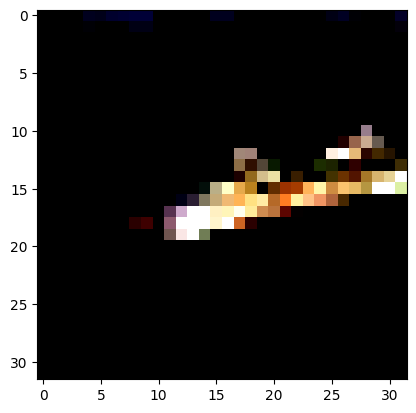

In [20]:
imshow(images[0])# 하이퍼파라미터(Hyperparameter)

# 하이퍼파라미터(Hyperparameter)는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수입니다.
# 서로 다른 하이퍼파라미터 값은 모델 학습과 수렴율(convergence rate)에 영향을 미칠 수 있습니다.

# 학습 시에는 다음과 같은 하이퍼파라미터를 정의합니다:
# 에폭(epoch) 수 - 데이터셋을 반복하는 횟수

# 배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수

# 학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있습니다.


In [21]:
# 최적화 단계(Optimization Loop)

# 하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있습니다. 최적화 단계의 각 반복(iteration)을 에폭이라고 부릅니다.

# 하나의 에폭은 다음 두 부분으로 구성됩니다:
# 학습 단계(train loop) - 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴합니다.

# 검증/테스트 단계(validation/test loop) - 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복(iterate)합니다.

In [22]:
# 손실 함수(loss function)

# 학습용 데이터를 제공하면, 학습되지 않은 신경망은 정답을 제공하지 않을 확률이 높습니다.
# 손실 함수(loss function)는 획득한 결과와 실제 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화하려고 합니다.
#  주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실(loss)을 계산합니다.

# 손실 함수 초기화

loss_fn = nn.CrossEntropyLoss()

In [23]:
# 옵티마이저(Optimizer)

# 최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정입니다.
# 최적화 알고리즘은 이 과정이 수행되는 방식(여기에서는 확률적 경사하강법(SGD; Stochastic Gradient Descent))을 정의합니다

# 학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 등록하여 옵티마이저를 초기화합니다.





In [24]:
# 학습 단계(loop)에서 최적화는 세단계로 이뤄집니다:
# optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다.

# loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파합니다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.

# 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.

In [25]:

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [26]:
# training 메소드 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Resnet50()
net = net.to(device)
cudnn.benchmark=True

lr_set = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr_set, momentum=0.9, weight_decay = 0.0002)
cut_mix_lam=1
def train(epoch):
    print(f'\n[Train epoch: {epoch}]')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # generate mixed sample
        if cut_mix_lam>0 :
          lam = np.random.beta(cut_mix_lam, cut_mix_lam)
          rand_index = torch.randperm(inputs.size()[0]).cuda()
          target_a = targets
          target_b = targets[rand_index]
          bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
          inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
          # adjust lambda to exactly match pixel ratio
          lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))

        optimizer.zero_grad()
        outputs = net(inputs)
        if cut_mix_lam>0 :
          loss = loss_fn(outputs, target_a) * lam + loss_fn(outputs, target_b) * (1. - lam)
        else :
          loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 99:
            print('\nCurrent batch:', str(batch_idx+1))
            print('Current train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current train loss:', loss.item())

    print('\nTotal train accuarcy:', 100. * correct / total)
    print('Total train loss:', train_loss)

In [27]:
# test 메소드 정의


def test(epoch):
    print(f'\n[ Test epoch: {epoch} ]')
    net.eval()
    loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        loss += loss_fn(outputs, targets).item()
        total += targets.size(0)

        _,predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(net, './checkpoint/cutmix_resnet50_ImageNet_model.pt')
    torch.save(net.state_dict(), './checkpoint/cutmix_resnet50_ImageNet_state_dict.pt')
    torch.save({
        'model' : net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, './checkpoint/cutmix_resnet50_ImageNet_all.tar')
    print('Model Saved!')

In [28]:
def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = lr_set
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [ ]:
#실제 동작부
for epoch in range(0,200):

    train(epoch)
    test(epoch)


[Train epoch: 0]


<ipython-input-25-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-25-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det


Current batch: 100
Current train accuracy: 0.03125
Current train loss: 2.375598907470703

Current batch: 200
Current train accuracy: 0.0625
Current train loss: 2.3186697959899902

Current batch: 300
Current train accuracy: 0.125
Current train loss: 2.2500016689300537

Current batch: 400
Current train accuracy: 0.15625
Current train loss: 2.2858285903930664

Current batch: 500
Current train accuracy: 0.21875
Current train loss: 2.294877767562866

Current batch: 600
Current train accuracy: 0.21875
Current train loss: 2.1066091060638428

Current batch: 700
Current train accuracy: 0.125
Current train loss: 2.191124677658081

Current batch: 800
Current train accuracy: 0.25
Current train loss: 2.1008028984069824

Current batch: 900
Current train accuracy: 0.1875
Current train loss: 2.204413414001465

Current batch: 1000
Current train accuracy: 0.3125
Current train loss: 2.054924726486206

Current batch: 1100
Current train accuracy: 0.21875
Current train loss: 2.176156997680664

Current batc